# Importing libraries

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
plt.style.use('seaborn-darkgrid')
tqdm.pandas()

# Loading the data
The warning is fine because columns with mixed types get converted to objects. 
We'll make sure everything has the right type in the next cell.

In [6]:
nrows = 10000 #Sizing down the dataset is useful for prototyping and evaluating computational times
df = pd.read_csv('Fire_Department_Calls_for_Service.csv', nrows=nrows)

# Data cleaning 
Everything not explicitly handled here should have type "object"

In [10]:
#Data dictionary so we can make sure everything is the right type
data_dict = pd.read_csv('DataDictionary.csv')

#List of datetime columns
date_columns = list(data_dict[data_dict['Data Type'] == 'Date & Time']['Field Name'])

#This column appears to be missing
date_columns.remove('AVL Validated On Scene DtTm')

#Converting to datetimes
for column in date_columns:
    #Specifying the formats makes date parsing way faster even though it's not elegant
    if "Date" in column:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y')
    else:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %I:%M:%S %p')
        
#List of numeric columns
numeric_columns = list(data_dict[data_dict['Data Type'] == 'Numeric']['Field Name'])

#Really these should be ints, but the float type lets us leave missing values as nans
df[numeric_columns] = df[numeric_columns].astype(float)
       
#List of boolean columns
bool_columns = list(data_dict[data_dict['Data Type'] == 'Boolean (True/False)']['Field Name'])
df[bool_columns] = df[bool_columns].astype(bool)

#Serialize the cleaned dataframe so we don't have to wait as long if we need to reload data
df.to_pickle('cleaned_fire_data')
        

# Task 1

## Adding turnout time and hour of day to dataframe

In [125]:
#Simple subtraction of response timestamp (enroute) and dispatch timestamp
df['turnout_time'] = df['Response DtTm'] - df['Dispatch DtTm']

#Converting the time delta to seconds
df['turnout_time'] = df['turnout_time'].progress_apply(lambda x: x.total_seconds())

#Adding hour of day based on when the call was received
df['hour'] = df['Received DtTm'].progress_apply(lambda x: x.hour)

#Adding boolean variable that indicates whether call is recieved during daytime or evening hours
daytime_hours = np.arange(6,22)
df['daytime'] = df['hour'].isin(daytime_hours)

100%|██████████| 10000/10000 [00:00<00:00, 262855.35it/s]


## Making a new dataframe containing only rows where the turnout time is defined

In [126]:
turnout_df = df[~np.isnan(df['turnout_time'])].reset_index(drop=True)

## What does the distribution of turnout times look like?
It's skewed right

Text(0, 0.5, 'Frequency')

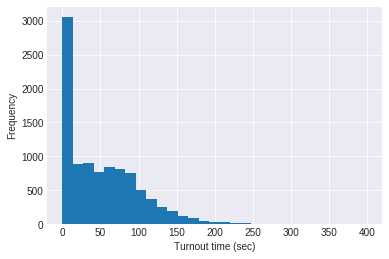

In [43]:
plt.hist(turnout_df['turnout_time'], bins=np.linspace(0,400,30))
plt.xlabel('Turnout time (sec)')
plt.ylabel('Frequency')

## Median turnout time by hour of day
I chose the median over the mean because of the skewness of the data and the presence of outliers

Text(0, 0.5, 'Median turnout time (sec)')

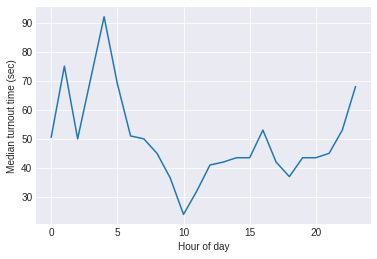

In [46]:
median_turnout = turnout_df[['hour','turnout_time']].groupby('hour').aggregate(np.median).reset_index()
plt.plot(median_turnout['hour'], median_turnout['turnout_time'])
plt.xlabel('Hour of day')
plt.ylabel('Median turnout time (sec)')

## CDF plot to compare daytime vs. evening turnout times
As expected, turnout times are generally longer for evening calls, but the previous plot reveals a spike 
specifically between 4:00-5:00 AM

Text(0, 0.5, 'Percentile')

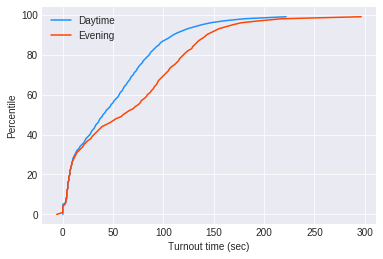

In [58]:
percentiles = np.arange(0,100)
daytime_values = np.percentile(turnout_df[turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(daytime_values, percentiles, color='dodgerblue')
evening_values = np.percentile(turnout_df[~turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(evening_values, percentiles, color='orangered')
plt.legend(['Daytime', 'Evening'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

## Looking at back to back responses

In [176]:
#adding "last available" column
turnout_df = turnout_df.sort_values(by='Available DtTm')
turnout_df['last_available'] = turnout_df.groupby('Unit ID')['Available DtTm'].transform(lambda x: x.shift(1))
turnout_df = turnout_df.reset_index(drop=True)

turnout_df['time_since_available'] = turnout_df['Dispatch DtTm'] - turnout_df['last_available']
turnout_df['time_since_available'] = turnout_df['time_since_available'].progress_apply(lambda x: x.total_seconds())
#Should be positive
turnout_df = turnout_df[turnout_df['time_since_available'] > 0]
turnout_df['back_to_back'] = turnout_df['time_since_available'] < 600

100%|██████████| 9600/9600 [00:00<00:00, 51579.82it/s]


Text(0, 0.5, 'Percentile')

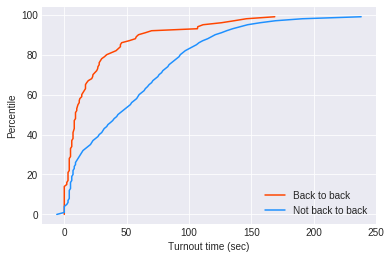

In [175]:
percentiles = np.arange(0,100)
back_to_back = np.percentile(turnout_df[turnout_df['back_to_back']]['turnout_time'], percentiles)
plt.plot(back_to_back, percentiles, color='orangered')

not_back_to_back= np.percentile(turnout_df[turnout_df['back_to_back']==False]['turnout_time'], percentiles)
plt.plot(not_back_to_back, percentiles, color='dodgerblue')
plt.legend(['Back to back', 'Not back to back'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

# Task 2

In [188]:
df['end_on_scene'] = df[['Available DtTm', 'Transport DtTm']].min(axis=1)
df['time_on_scene'] = df['end_on_scene'] - df['On Scene DtTm'] 
df['time_on_scene'] = df['time_on_scene'].progress_apply(lambda x: x.total_seconds())

#Removing outliers to help with analysis
on_scene = df[df['time_on_scene'] < 6000]
on_scene = on_scene[on_scene['turnout_time'] < 600]


100%|██████████| 10000/10000 [00:00<00:00, 126808.46it/s]


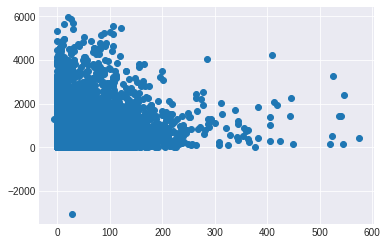

In [189]:
plt.scatter(on_scene['turnout_time'], on_scene['time_on_scene'])

In [191]:
on_scene[['time_on_scene','turnout_time']].corr()

,time_on_scene,turnout_time
time_on_scene,1.000000,-0.117237
turnout_time,-0.117237,1.000000
